In [0]:
# Import the required libraries.
import re
import math
import random
import collections
import operator
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict, Counter
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

random.seed(11)
np.random.seed(11)

In [2]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation, Masking, Flatten
from keras.optimizers import Adam, SGD
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [3]:
from google.colab import files
uploaded = files.upload()

Saving Brown_train.txt to Brown_train.txt


In [0]:
def parse_sentence(sentence):
    '''
    Function for parsing the words and tags from the
    sentences of the input corpus.
    '''
    word_tag_pairs = sentence.split(" ")
    words = []
    tags = []

    for i, word_tag in enumerate(word_tag_pairs):
        word, tag = word_tag.strip().rsplit('/', 1)
        words.append(word)
        tags.append(tag)
        
    return words, tags

In [0]:
# Parse the sentences into a list.
parsed_sentences = []

with open('./Brown_train.txt', 'r') as file:
    sentences = file.readlines()

    for sentence in sentences:
        sentence = sentence.strip()
        parsed_sentences.append(parse_sentence(sentence))

In [0]:
def get_vocab(X_train, Y_train):
    '''
    Function for building the vocabulary from the training set of
    words and tags.
    '''
    vocabulary2id = dict()    
    tag2id = dict()
    vocabulary2id['PAD'] = 0
    vocabulary2id['UNK'] = 1

    for sent in X_train:
        for word in sent:
            if word not in vocabulary2id.keys():
                vocabulary2id[word] = len(vocabulary2id)
    
    tag2id['PAD'] = 0
    for sent in Y_train:
        for tag in sent:
            if tag not in tag2id.keys():
                tag2id[tag] = len(tag2id)
    
    return vocabulary2id, tag2id

def get_word_tag_counts(X_train, Y_train, vocabulary2id, tag2id):
    '''
    Function for calculating the counts pertaining to the
    individual word tags.
    '''
    wordcount = defaultdict(int)
    tagcount = defaultdict(int)
    tagpaircount = defaultdict(int)
    tagtriplecount = defaultdict(int)
    
    for sent in X_train:
        for word in sent:
            wordcount[word] += 1
    
    for sent in Y_train:
        for tag in sent:
            tagcount[tag] += 1
    
    for sent in Y_train:
        for i in range(len(sent) - 1):
            tagpaircount[sent[i], sent[i + 1]] += 1

    for sent in Y_train:
        for i in range(len(sent) - 2):
            tagtriplecount[sent[i], sent[i + 1], sent[i + 2]] += 1
    
    return wordcount, tagcount, tagpaircount, tagtriplecount

In [9]:
parsed_sentences[:5]

[(['At',
   'that',
   'time',
   'highway',
   'engineers',
   'traveled',
   'rough',
   'and',
   'dirty',
   'roads',
   'to',
   'accomplish',
   'their',
   'duties',
   '.'],
  ['ADP',
   'DET',
   'NOUN',
   'NOUN',
   'NOUN',
   'VERB',
   'ADJ',
   'CONJ',
   'ADJ',
   'NOUN',
   'PRT',
   'VERB',
   'DET',
   'NOUN',
   '.']),
 (['Using',
   'privately-owned',
   'vehicles',
   'was',
   'a',
   'personal',
   'hardship',
   'for',
   'such',
   'employees',
   ',',
   'and',
   'the',
   'matter',
   'of',
   'providing',
   'state',
   'transportation',
   'was',
   'felt',
   'perfectly',
   'justifiable',
   '.'],
  ['VERB',
   'ADJ',
   'NOUN',
   'VERB',
   'DET',
   'ADJ',
   'NOUN',
   'ADP',
   'ADJ',
   'NOUN',
   '.',
   'CONJ',
   'DET',
   'NOUN',
   'ADP',
   'VERB',
   'NOUN',
   'NOUN',
   'VERB',
   'VERB',
   'ADV',
   'ADJ',
   '.']),
 (['Once',
   'the',
   'principle',
   'was',
   'established',
   ',',
   'the',
   'increase',
   'in',
   'state-owned'

In [0]:
def build_model():
    model = Sequential()
    model.add(InputLayer(input_shape=(5, )))
    model.add(Embedding(len(vocabulary2id), 100))
    model.add(Flatten())
    model.add(Dense(len(tag2id)))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(0.001),
                  metrics=['accuracy'])
    model.summary()
    return model

In [0]:
def id2onehot(Y, numtags):
    out = []
    for s in Y:
        out.append(np.zeros(numtags))
        out[-1][s] = 1.0
    return np.array(out)

In [0]:
def make_example(words, vocabulary2id):
    words_new = ['PAD', 'PAD'] + words + ['PAD', 'PAD']
    examples = []
    for i in range(len(words)):
        context_words = words_new[i: i + 5]
        context_word_idx = [vocabulary2id[w] if w in vocabulary2id.keys() else vocabulary2id['UNK'] for w in context_words]
        examples.append(context_word_idx)

    return examples

In [13]:
# Build the test and training sets of sentences.
kf = KFold(n_splits = 3, shuffle = False)
parsed_sentences = np.asarray(parsed_sentences)
scores = []
scores1 = []
y_pred_idx = []
y_pred_idx1 = []
y_test_idx = []
y_test_idx1 = []

preds_all_folds = []
golds_all_folds = []

for fold_num, (train_index, test_index) in enumerate(kf.split(parsed_sentences)):
    train_data = parsed_sentences[train_index]
    test_data = parsed_sentences[test_index]
    X_train = [a[0] for a in train_data]
    Y_train = [a[1] for a in train_data]
    X_test = [a[0] for a in test_data]
    Y_test = [a[1] for a in test_data]

    # Build the vocabulary and word counts.
    vocabulary2id, tag2id = get_vocab(X_train, Y_train)

    X_train_ids = []
    Y_train_ids = []
    for x_sent, y_sent in zip(X_train, Y_train):
        X_train_ids.extend(make_example(x_sent, vocabulary2id))
        Y_train_ids.extend([tag2id[word] if word in tag2id.keys() else tag2id['UNK'] for word in y_sent])

    X_test_ids = []
    Y_test_ids = []
    for x_sent, y_sent in zip(X_test, Y_test):
        X_test_ids.extend(make_example(x_sent, vocabulary2id))
        Y_test_ids.extend([tag2id[word] if word in tag2id.keys() else tag2id['UNK'] for word in y_sent])
    
    X_train_ids = np.asarray(X_train_ids)
    X_test_ids = np.asarray(X_test_ids)

    Y_train_onehot = id2onehot(Y_train_ids, len(tag2id))
    Y_test_onehot = id2onehot(Y_test_ids, len(tag2id))

    model = build_model()
    model.fit(X_train_ids, Y_train_onehot, batch_size=128, epochs=5, validation_split=0.2)

    predictions = model.predict(X_test_ids)

    predictions_argmax = np.argmax(predictions, axis=-1)

    y_pred_nopad = predictions_argmax[:]
    y_true_nopad = Y_test_ids[:]

    preds_all_folds.append(y_pred_nopad)
    golds_all_folds.append(y_true_nopad)

    y_pred_nopad = np.asarray(y_pred_nopad)
    y_true_nopad = np.asarray(y_true_nopad)
    test_accuracy = (y_pred_nopad == y_true_nopad).mean()
    print('Fold {} test_accuracy: {}'.format(fold_num + 1, test_accuracy))
    prec, rec, fscore, _ = precision_recall_fscore_support(y_true_nopad, y_pred_nopad, average = 'weighted')
    print('Fold {} Precision: {} Recall: {} F1-Score: {}'.format(fold_num + 1, prec, rec, fscore))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5, 100)            2211500   
_________________________________________________________________
flatten_1 (Flatten)          (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 13)                6513      
_________________________________________________________________
activation_1 (Activation)    (None, 13)                0         
Total params: 2,218,013
Trainable params: 2,218,013
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 238759 samples, validate on 59690 samples
Epoch 1/5
238759/238759 [==============================] - 11s 47us/step - loss: 0.3786 - accuracy: 0.9069 - val_loss: 0.1531 - val_accuracy: 0.9528
Epoch 2/5
238759/238759 [==============================] - 9s 39us/step - loss: 0.0628 - accuracy: 0.9817 - val_loss: 0.1353 - val_accuracy: 0.9573
Epoch 3/5
238759/238759 [==============================] - 9s 39us/step - loss: 0.0342 - accuracy: 0.9893 - val_loss: 0.1396 - val_accuracy: 0.9553
Epoch 4/5
238759/238759 [==============================] - 9s 39us/step - loss: 0.0227 - accuracy: 0.9929 - val_loss: 0.1440 - val_accuracy: 0.9551
Epoch 5/5
238759/238759 [==============================] - 9s 40us/step - loss: 0.0161 - accuracy: 0.9951 - val_loss: 0.1541 - val_accuracy: 0.9536
Fold 1 test_accuracy: 0.9175521046178995
Fold 1 Precision: 0.9175708490712462 Recall: 0.9175521046178995 F1-Score: 0.9162935613787996


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 5, 100)            2850100   
_________________________________________________________________
flatten_2 (Flatten)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 13)                6513      
_________________________________________________________________
activation_2 (Activation)    (None, 13)                0         
Total params: 2,856,613
Trainable params: 2,856,613
Non-trainable params: 0
_________________________________________________________________
Train on 318057 samples, validate on 79515 samples
Epoch 1/5
318057/318057 [==============================] - 14s 45us/step - loss: 0.3303 - accuracy: 0.9154 - val_loss: 0.1529 - val_accuracy: 0.9517
Epoch 2/5
318057/318057 [=================

In [14]:
print("---Averaged Results over all the epochs---")
test_accuracy = (np.asarray(preds_all_folds[0]) == np.asarray(golds_all_folds[0])).mean()
print('Average K-Fold Test Accuracy: {}'.format(test_accuracy))
prec, rec, fscore, _ = precision_recall_fscore_support(preds_all_folds[0], golds_all_folds[0], average = 'weighted')
print('Average K-Fold Precision: {} Recall: {} F1-Score: {}'.format(prec, rec, fscore))

---Averaged Results over all the epochs---
Average K-Fold Test Accuracy: 0.9175521046178995
Average K-Fold Precision: 0.9219477576557498 Recall: 0.9175521046178995 F1-Score: 0.9188106478569993


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
id2tag = {v: k for k, v in tag2id.items()}
print(classification_report([id2tag[i] for i in golds_all_folds[0]], [id2tag[i] for i in preds_all_folds[0]]))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           .       0.98      1.00      0.99     29621
         ADJ       0.89      0.90      0.90     36028
         ADP       0.99      0.99      0.99      8082
         ADV       0.82      0.74      0.78     20552
        CONJ       0.87      0.92      0.90     63728
         DET       0.89      0.82      0.85     10653
        NOUN       1.00      1.00      1.00     26322
         NUM       0.97      0.97      0.97      4859
         PAD       0.00      0.00      0.00         0
        PRON       0.97      0.62      0.76      4728
         PRT       0.96      0.96      0.96     35159
        VERB       0.80      0.89      0.84      4675
           X       0.53      0.19      0.29       293

    accuracy                           0.92    244700
   macro avg       0.82      0.77      0.79    244700
weighted avg       0.92      0.92      0.92    244700



In [0]:
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    plt.show()

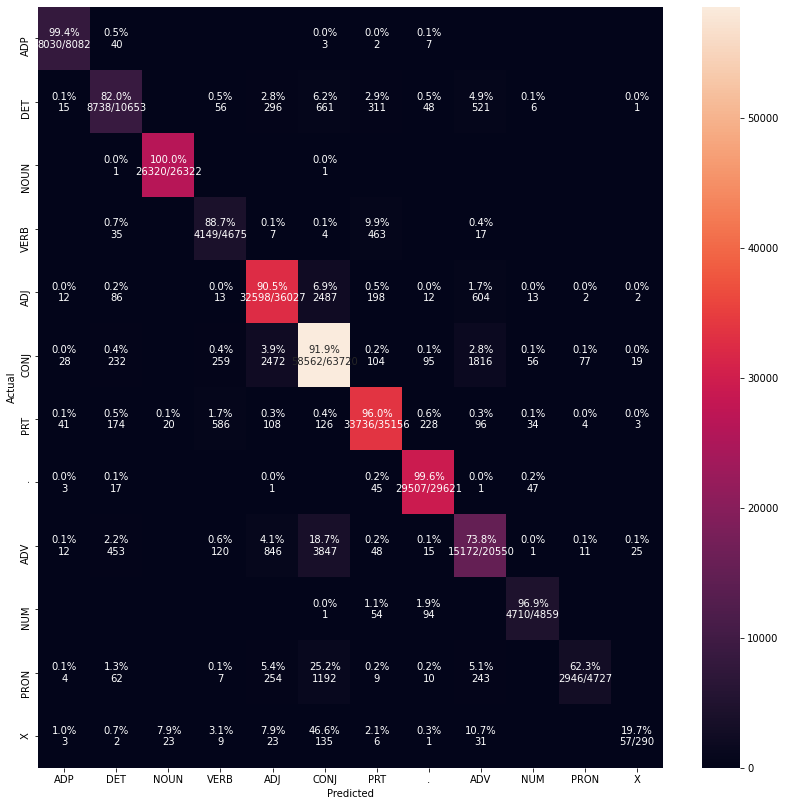

In [26]:
cm_analysis([id2tag[i] for i in golds_all_folds[0]], [id2tag[i] for i in preds_all_folds[0]], sorted(tag2id.keys(), key=lambda k: tag2id[k])[1:], ymap=None, figsize=(14, 14))

In [39]:
print("Tag-wise counts and accuracies\n--\n")
print("Tag\tGold Tag Count\tTotal predicted correctly\tTotal predicted incorrectly\tAccuracy")
gold_counts = Counter([id2tag[i] for i in golds_all_folds[0]])
pred_counts_correct = Counter([id2tag[t] for i, t in enumerate(preds_all_folds[0]) if t == golds_all_folds[0][i]])
pred_counts_incorrect = Counter([id2tag[t] for i, t in enumerate(preds_all_folds[0]) if t != golds_all_folds[0][i]])
for tag in gold_counts.keys():
  print(f"{tag}\t{gold_counts[tag]}\t\t{pred_counts_correct[tag]}\t\t\t\t{pred_counts_incorrect[tag]}\t\t\t\t{pred_counts_correct[tag] / gold_counts[tag]}")

Tag-wise counts and accuracies
--

Tag	Gold Tag Count	Total predicted correctly	Total predicted incorrectly	Accuracy
PRT	35159		33736				1240				0.9595267214653431
.	29621		29507				510				0.9961513790891597
CONJ	63728		58562				8457				0.9189367311072056
ADJ	36028		32598				4007				0.9047962695681137
ADV	20552		15172				3329				0.738224990268587
ADP	8082		8030				118				0.9935659490225192
VERB	4675		4149				1050				0.8874866310160427
NOUN	26322		26320				43				0.9999240179317681
DET	10653		8738				1102				0.8202384304890641
PRON	4728		2946				94				0.6230964467005076
NUM	4859		4710				157				0.9693352541675242
X	293		57				50				0.1945392491467577
